In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns 

import numpy as np
# IP import warnings because of "module 'numpy' has no attribute 'warnings'"
import warnings
np.warnings = warnings
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score

# # import from scripts
# import os
# os.chdir(os.path.expanduser("D:\\intr_timescales\\isttc\\scripts"))
# # os.chdir(os.path.expanduser("C:\\Users\\ipoch\\Documents\\repos\\isttc\\scripts"))
# from calculate_acf import acf_sttc, acf_pearsonr_trial_avg, acf_sttc_trial_avg

import os
current_wd = os.getcwd()
#os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
os.chdir(os.path.abspath("C:\\Users\\ipoch\\Documents\\repos\\isttc\\scripts"))
from calculate_tau import fit_single_exp, func_single_exp_monkey
from cfg_global import project_folder_path
from calculate_acf import acf_sttc, acf_pearsonr_trial_avg, acf_sttc_trial_avg, acf_sttc_trial_concat
os.chdir(current_wd)

In [2]:
fig_folder = project_folder_path + 'results\\synthetic_data\\fig_drafts_paper_reduce\\'

### Load the data

In [3]:
spike_times = np.load(project_folder_path + 'results\\synthetic_data\\test_full_split\\spike_times.npy')
ou_spiketrain_binned = np.load(project_folder_path + 'results\\synthetic_data\\test_full_split\\ou_spiketrain_binned.npy')

In [4]:
num_lags = 20
bin_size = 50
sttc_dt = 49
signal_len = 100000

In [5]:
def func_exp_abc_like(x, a, tau):
    return a * np.exp(-x/tau) 

### Calculate acf and sttc for the full signal

In [7]:
#todo 21 from asf and 20 from isttc - fix that!
# Using acf func
spike_train_binned_acf = acf(ou_spiketrain_binned[0], nlags=num_lags)
print('spike_train_binned_acf shape {}, \nspike_train_binned_acf: {}'.format(spike_train_binned_acf.shape, spike_train_binned_acf))

# Using isttc
spike_train_acf = acf_sttc(spike_times, num_lags, lag_shift_=bin_size, sttc_dt_=sttc_dt, signal_length_=signal_len, verbose_=False)
print('spike_train_acf shape {}, \nspike_train_acf: {}'.format(len(spike_train_acf), spike_train_acf))

# calculate tau
spike_train_binned_popt, _ = curve_fit(func_exp_abc_like, np.linspace(0,20,21), spike_train_binned_acf, maxfev=5000)
spike_train_binned_tau_ms = spike_train_binned_popt[1] * bin_size
print('spike_train_binned_popt: {}, spike_train_binned_tau_ms: {}'.format(spike_train_binned_popt, spike_train_binned_tau_ms))

spike_train_popt, _ = curve_fit(func_exp_abc_like, np.linspace(0,20,21), spike_train_acf, maxfev=5000)
spike_train_tau_ms = spike_train_popt[1] * bin_size
print('spike_train_popt: {}, spike_train_tau_ms: {}'.format(spike_train_popt, spike_train_tau_ms))

spike_train_binned_acf shape (21,), 
spike_train_binned_acf: [ 1.          0.49215131  0.2821505   0.1616106   0.08844024  0.07648782
  0.02344463 -0.00867316 -0.01960204 -0.04462376 -0.03282076 -0.03199797
 -0.04016174 -0.00992729 -0.01154496 -0.00658597  0.01306548  0.04077162
  0.06785523  0.04134784  0.0492438 ]
spike_train_acf shape 21, 
spike_train_acf: [1.0, 0.7706103545583978, 0.4204157053544422, 0.23715788712972305, 0.13207384122926805, 0.07066300033196116, 0.019195003371161166, -0.009948068613723278, -0.01636808389622811, -0.031813959125070665, -0.030645304931782455, -0.04569479773635923, -0.035081240532766525, -0.028599466254498197, -0.02127989014486014, -0.00855320786148805, 0.02685765707447492, 0.054989314885117546, 0.0638279371377392, 0.08527762793619001, 0.0993537544071131]
spike_train_binned_popt: [0.98962855 1.56667209], spike_train_binned_tau_ms: 78.33360427659365
spike_train_popt: [1.06055305 2.08544567], spike_train_tau_ms: 104.27228365267693


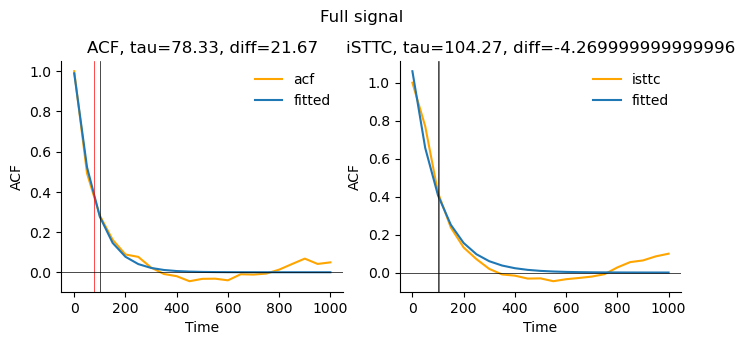

In [9]:
fig, axes = plt.subplots(1,2, figsize=(8,3))

axes[0].plot(np.linspace(0,20,21), spike_train_binned_acf, c='orange', label='acf')
axes[0].plot(np.linspace(0,20,21), func_exp_abc_like(np.linspace(0,20,21), spike_train_binned_popt[0], spike_train_binned_popt[1]), label='fitted')
axes[0].axvline(x=spike_train_binned_popt[1], lw=0.5, color='red')
axes[0].set_title('ACF, tau={}, diff={}'.format(np.round(spike_train_binned_tau_ms, 2), 100-np.round(spike_train_binned_tau_ms, 2)))
axes[0].set_xticks(np.linspace(0,20,6))
axes[0].set_xticklabels(np.linspace(0,1000,6).astype(int))

axes[1].plot(np.linspace(0,20,21), spike_train_acf, c='orange', label='isttc')
axes[1].plot(np.linspace(0,20,21), func_exp_abc_like(np.linspace(0,20,21), spike_train_popt[0], spike_train_popt[1]), label='fitted')
axes[1].axvline(x=spike_train_popt[1], lw=0.5, color='red')
axes[1].set_title('iSTTC, tau={}, diff={}'.format(np.round(spike_train_tau_ms, 2), 100-np.round(spike_train_tau_ms, 2)))
axes[1].set_xticks(np.linspace(0,20,6))
axes[1].set_xticklabels(np.linspace(0,1000,6).astype(int))

fig.suptitle('Full signal', y=1.05)

for ax in axes.flat:
    ax.legend(frameon=False)
    ax.axvline(x=2, lw=0.5, color='k')
    ax.axhline(y=0, lw=0.5, color='k')
    ax.set_xlabel('Time')
    ax.set_ylabel('ACF')

sns.despine()

#fig.savefig('Q:\\Personal\\Irina\\projects\\isttc\\results\\synthetic_data\\test_full_split\\figs\\' + 'full_signal.png' , bbox_inches='tight')

### Calculate acf and sttc for the split signal

In [10]:
n_trials = 100
trial_len = num_lags * bin_size

In [11]:
ou_spiketrain_binned_trials = np.reshape(ou_spiketrain_binned, (n_trials, num_lags))
print('ou_spiketrain_binned_trials shape: {}'.format(ou_spiketrain_binned_trials.shape))

ou_spiketrain_binned_trials shape: (100, 20)


In [12]:
bins =  np.arange(0, signal_len+trial_len, trial_len)
inds = np.digitize(spike_times, bins)
spike_times_trial_l = []
spike_times_trial_shifted_l = []
for i in range(n_trials):
    spike_times_trail = spike_times[inds == i+1]
    spike_times_trail_shifted = spike_times_trail - i*trial_len
    spike_times_trial_l.append(spike_times_trail)
    spike_times_trial_shifted_l.append(spike_times_trail_shifted)

In [13]:
acf_acf_l = []
tau_ms_acf_l = []
popt_acf_l = []
fit_r_squared_acf_l = []

for i in range(n_trials):
    spike_train_binned_acf_trial = acf(ou_spiketrain_binned_trials[i, :], nlags=num_lags)
    #print('spike_train_binned_acf shape {}, \nspike_train_binned_acf: {}'.format(spike_train_binned_acf.shape, spike_train_binned_acf))

    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            spike_train_binned_trial_popt, _ = curve_fit(func_exp_abc_like, np.linspace(0,19,20), spike_train_binned_acf_trial, maxfev=5000)
            spike_train_binned_trial_tau_ms = spike_train_binned_trial_popt[1] * bin_size
            #print('spike_train_binned_popt: {}, spike_train_binned_tau_ms: {}'.format(spike_train_binned_popt, spike_train_binned_tau_ms))
            # fit r-squared
            y_pred = func_exp_abc_like(np.linspace(0,19,20), *spike_train_binned_trial_popt)
            fit_r_squared = r2_score(spike_train_binned_acf_trial, y_pred)
        except ValueError as ve:
            print('ValueError: {}'. format(ve))
            print('Possible reason: acf contains NaNs, low spike count')
            spike_train_binned_trial_popt, spike_train_binned_trial_tau_ms = np.nan, np.nan
        except RuntimeWarning as re:
            print('RuntimeWarning: {}'. format(re))
            spike_train_binned_trial_popt, spike_train_binned_trial_tau_ms = np.nan, np.nan
        except OptimizeWarning as o:
            print('OptimizeWarning: {}'. format(o))
            spike_train_binned_trial_popt, spike_train_binned_trial_tau_ms = np.nan, np.nan

    acf_acf_l.append(spike_train_binned_acf_trial)
    tau_ms_acf_l.append(spike_train_binned_trial_tau_ms)
    popt_acf_l.append(spike_train_binned_trial_popt)
    fit_r_squared_acf_l.append(fit_r_squared)

ValueError: array must not contain infs or NaNs
Possible reason: acf contains NaNs, low spike count


C:\Users\ipoch\anaconda3\envs\ephys_data_loader\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


In [14]:
acf_isttc_l = []
tau_ms_isttc_acf_l = []
popt_isttc_l = []
fit_r_squared_isttc_l = []

for i in range(n_trials):
    spike_train_acf_trial = acf_sttc(spike_times_trial_shifted_l[i], num_lags, lag_shift_=bin_size, sttc_dt_=sttc_dt, 
                                     signal_length_=trial_len, verbose_=False)
    # print('spike_train_acf shape {}, \nspike_train_acf: {}'.format(len(spike_train_acf), spike_train_acf))

    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            spike_train_trial_popt, _ = curve_fit(func_exp_abc_like, np.linspace(0,19,20), spike_train_acf_trial, maxfev=5000)
            spike_train_trial_tau_ms = spike_train_trial_popt[1] * bin_size
            #print('spike_train_popt: {}, spike_train_tau_ms: {}'.format(spike_train_popt, spike_train_tau_ms))
            y_pred = func_exp_abc_like(np.linspace(0,19,20), *spike_train_trial_popt)
            fit_r_squared = r2_score(spike_train_acf_trial, y_pred)
        except ValueError as ve:
            print('ValueError: {}'. format(ve))
            print('Possible reason: acf contains NaNs, low spike count')
            spike_train_trial_popt, spike_train_trial_tau_ms = np.nan, np.nan
        except RuntimeWarning as re:
            print('RuntimeWarning: {}'. format(re))
            spike_train_trial_popt, spike_train_trial_tau_ms = np.nan, np.nan
        except OptimizeWarning as o:
            print('OptimizeWarning: {}'. format(o))
            spike_train_trial_popt, spike_train_trial_tau_ms = np.nan, np.nan

    acf_isttc_l.append(spike_train_acf_trial)
    tau_ms_isttc_acf_l.append(spike_train_trial_tau_ms)
    popt_isttc_l.append(spike_train_trial_popt)
    fit_r_squared_isttc_l.append(fit_r_squared)

### Calculate acf and sttc for the split signal monkey style

In [15]:
ou_spiketrain_binned_trials.shape

(100, 20)

In [16]:
acf_matrix_trail_avg, acf_average_trial_avg = acf_pearsonr_trial_avg(ou_spiketrain_binned_trials, n_lags_=num_lags)
spike_train_trial_avg_popt, _ = curve_fit(func_exp_abc_like, np.linspace(0,19,20), acf_average_trial_avg, maxfev=5000)
spike_train_trial_avg_tau_ms = spike_train_trial_avg_popt[1] * bin_size
print(spike_train_trial_avg_tau_ms)

n_bins to use 20
79.4132365678463


<Axes: >

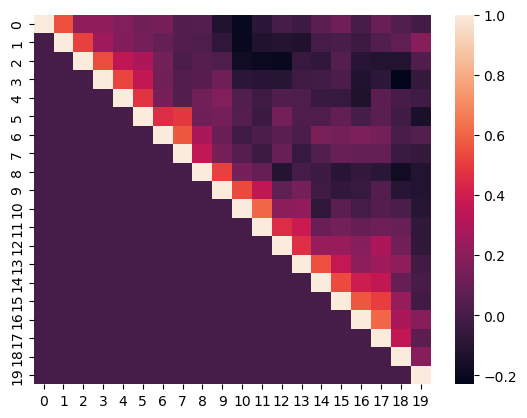

In [17]:
sns.heatmap(acf_matrix_trail_avg)

In [18]:
#acf_sttc_trial_avg(spike_train_l_, lag_shift_=50, zero_padding_len_=150, fs_=1000, sttc_dt_=25, verbose_=True)

sttc_matrix_trail_avg, sttc_average_trial_avg = acf_sttc_trial_avg(spike_times_trial_shifted_l, 
                                                                   lag_shift_=bin_size, 
                                                                   zero_padding_len_=120, 
                                                                   fs_=1000, 
                                                                   sttc_dt_=49, 
                                                                   verbose_=False)
spike_train_trial_avg_sttc_popt, _ = curve_fit(func_exp_abc_like, np.linspace(0,19,20), sttc_average_trial_avg, maxfev=5000)
spike_train_trial_avg_sttc_tau_ms = spike_train_trial_avg_sttc_popt[1] * bin_size
print(spike_train_trial_avg_sttc_tau_ms)

TypeError: acf_sttc_trial_avg() got an unexpected keyword argument 'fs_'

<Axes: >

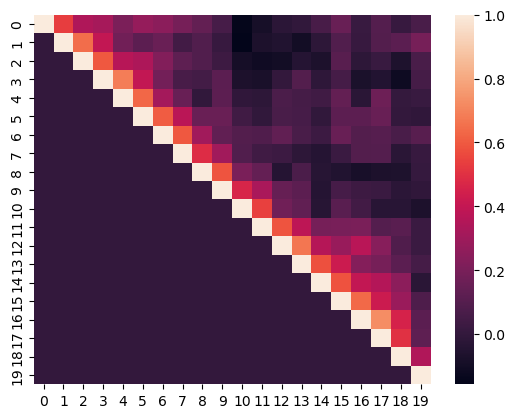

In [62]:
sns.heatmap(sttc_matrix_trail_avg)

### Plots

#### N nans and < 0 or > 1000 values

In [19]:
# make a frame
acf_vs_isttc_df = pd.DataFrame(np.vstack((tau_ms_acf_l, tau_ms_isttc_acf_l)).T, columns=['tau_ms_acf', 'tau_ms_isttc'])
acf_vs_isttc_df['acf_diff'] = acf_vs_isttc_df['tau_ms_acf'] - 100 
acf_vs_isttc_df['isttc_diff'] = acf_vs_isttc_df['tau_ms_isttc'] - 100 
acf_vs_isttc_df['acf_diff_abs'] = np.abs(acf_vs_isttc_df['acf_diff'])
acf_vs_isttc_df['isttc_diff_abs'] = np.abs(acf_vs_isttc_df['isttc_diff'])
acf_vs_isttc_df

,tau_ms_acf,tau_ms_isttc,acf_diff,isttc_diff,acf_diff_abs,isttc_diff_abs
0,61.042398,107.834404,-38.957602,7.834404,38.957602,7.834404
1,49.835202,1233.284681,-50.164798,1133.284681,50.164798,1133.284681
2,48.460893,64.409293,-51.539107,-35.590707,51.539107,35.590707
3,23.271214,53.904686,-76.728786,-46.095314,76.728786,46.095314
4,55.456678,71.353317,-44.543322,-28.646683,44.543322,28.646683
...,...,...,...,...,...,...
95,NaN,32.286664,NaN,-67.713336,NaN,67.713336
96,33.770887,42.936795,-66.229113,-57.063205,66.229113,57.063205
97,54.024329,523.497634,-45.975671,423.497634,45.975671,423.497634
98,86.878836,144.346241,-13.121164,44.346241,13.121164,44.346241


In [20]:
acf_vs_isttc_df_no_nans = acf_vs_isttc_df.dropna()
acf_vs_isttc_df_no_nans

,tau_ms_acf,tau_ms_isttc,acf_diff,isttc_diff,acf_diff_abs,isttc_diff_abs
0,61.042398,107.834404,-38.957602,7.834404,38.957602,7.834404
1,49.835202,1233.284681,-50.164798,1133.284681,50.164798,1133.284681
2,48.460893,64.409293,-51.539107,-35.590707,51.539107,35.590707
3,23.271214,53.904686,-76.728786,-46.095314,76.728786,46.095314
4,55.456678,71.353317,-44.543322,-28.646683,44.543322,28.646683
...,...,...,...,...,...,...
94,8.372588,43.350262,-91.627412,-56.649738,91.627412,56.649738
96,33.770887,42.936795,-66.229113,-57.063205,66.229113,57.063205
97,54.024329,523.497634,-45.975671,423.497634,45.975671,423.497634
98,86.878836,144.346241,-13.121164,44.346241,13.121164,44.346241


In [21]:
acf_vs_isttc_df_no_nans_0_1000 = acf_vs_isttc_df_no_nans.query('tau_ms_acf <= 1000 and tau_ms_isttc <= 1000').copy()
acf_vs_isttc_df_no_nans_0_1000

,tau_ms_acf,tau_ms_isttc,acf_diff,isttc_diff,acf_diff_abs,isttc_diff_abs
0,61.042398,107.834404,-38.957602,7.834404,38.957602,7.834404
2,48.460893,64.409293,-51.539107,-35.590707,51.539107,35.590707
3,23.271214,53.904686,-76.728786,-46.095314,76.728786,46.095314
4,55.456678,71.353317,-44.543322,-28.646683,44.543322,28.646683
5,31.710033,50.801751,-68.289967,-49.198249,68.289967,49.198249
...,...,...,...,...,...,...
94,8.372588,43.350262,-91.627412,-56.649738,91.627412,56.649738
96,33.770887,42.936795,-66.229113,-57.063205,66.229113,57.063205
97,54.024329,523.497634,-45.975671,423.497634,45.975671,423.497634
98,86.878836,144.346241,-13.121164,44.346241,13.121164,44.346241


In [22]:
acf_vs_isttc_df_no_nans_0_1000.describe()

,tau_ms_acf,tau_ms_isttc,acf_diff,isttc_diff,acf_diff_abs,isttc_diff_abs
count,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000
mean,46.123705,113.280148,-53.876295,13.280148,54.434546,73.803418
std,21.887375,139.284253,21.887375,139.284253,20.440580,118.583091
min,0.922123,22.036633,-99.077877,-77.963367,7.172032,1.998490
25%,30.378144,53.176892,-69.621856,-46.823108,41.051776,25.459614
50%,45.810103,68.073943,-54.189897,-31.926057,54.189897,40.331098
75%,58.948224,88.576359,-41.051776,-11.423641,69.621856,56.027875
max,122.050942,744.866161,22.050942,644.866161,99.077877,644.866161


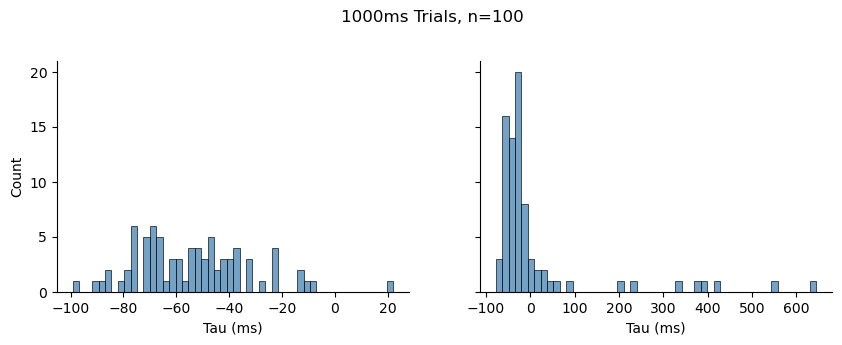

In [23]:
fig, axes = plt.subplots(1,2, figsize=(10,3), sharey=True)

sns.histplot(ax=axes[1], x=acf_vs_isttc_df_no_nans_0_1000['isttc_diff'].values, bins=50, stat='count', color='steelblue')
# axes[1].axvline(x=isttc_med, lw=1, color='red')
# axes[1].set_title('iSTTC, tau(med)={}, diff={}'.format(np.round(isttc_med, 2), np.round(100-isttc_med, 2)))

sns.histplot(ax=axes[0], x=acf_vs_isttc_df_no_nans_0_1000['acf_diff'].values, bins=50, stat='count', color='steelblue')
# axes[0].axvline(x=acf_med, lw=1, color='red')
# axes[0].set_title('ACF, tau(med)={}, diff={}'.format(np.round(acf_med, 2), np.round(100-acf_med, 2)))

fig.suptitle('1000ms Trials, n=100', y=1.05)

for ax in axes.flat:
    #ax.axvline(x=100, lw=1, color='k')
    ax.set_xlabel('Tau (ms)')
    #ax.set_xlim([0, 1000])

sns.despine()

#### Taus [0, 1000]

In [24]:
tau_ms_isttc_acf_a = np.asarray(tau_ms_isttc_acf_l)
tau_ms_isttc_acf_a_0_1000 = tau_ms_isttc_acf_a[tau_ms_isttc_acf_a <= 1000]
#print(tau_ms_isttc_acf_a_0_1000)

tau_ms_acf_a = np.asarray(tau_ms_acf_l)
tau_ms_acf_a_0_1000 = tau_ms_acf_a[tau_ms_acf_a <= 1000]
#print(tau_ms_acf_a_0_1000)

isttc_med = np.nanmedian(tau_ms_isttc_acf_a_0_1000)
acf_med = np.nanmedian(tau_ms_acf_a_0_1000)
print('isttc_med: {}, acf_med: {}'.format(isttc_med, acf_med))

isttc_mean = np.nanmean(tau_ms_isttc_acf_a_0_1000)
acf_mean = np.nanmean(tau_ms_acf_a_0_1000)
print('isttc_mean: {}, acf_mean: {}'.format(isttc_mean, acf_mean))

isttc_med: 66.39263740076203, acf_med: 46.55703262947137
isttc_mean: 109.20031968867036, acf_mean: 47.351743892099165


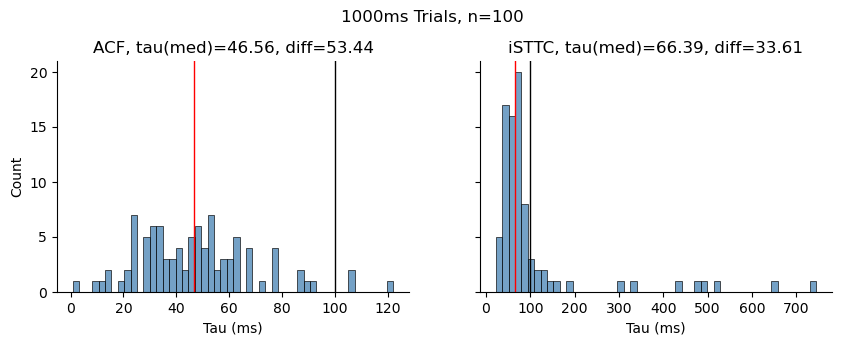

In [29]:
fig, axes = plt.subplots(1,2, figsize=(10,3), sharey=True)

sns.histplot(ax=axes[1], x=tau_ms_isttc_acf_a_0_1000, bins=50, stat='count', color='steelblue')
axes[1].axvline(x=isttc_med, lw=1, color='red')
axes[1].set_title('iSTTC, tau(med)={}, diff={}'.format(np.round(isttc_med, 2), np.round(100-isttc_med, 2)))

sns.histplot(ax=axes[0], x=tau_ms_acf_a_0_1000, bins=50, stat='count', color='steelblue')
axes[0].axvline(x=acf_med, lw=1, color='red')
axes[0].set_title('ACF, tau(med)={}, diff={}'.format(np.round(acf_med, 2), np.round(100-acf_med, 2)))

fig.suptitle('1000ms Trials, n=100', y=1.05)

for ax in axes.flat:
    ax.axvline(x=100, lw=1, color='k')
    ax.set_xlabel('Tau (ms)')
    #ax.set_xlim([0, 1000])

sns.despine()

fig.savefig(fig_folder + 'trials_1s_signal_0_1000.png' , bbox_inches='tight')
fig.savefig(fig_folder + 'trials_1s_signal_0_1000.svg' , bbox_inches='tight')

In [30]:
acf_vs_isttc_df_no_nans_0_1000

,tau_ms_acf,tau_ms_isttc,acf_diff,isttc_diff,acf_diff_abs,isttc_diff_abs
0,61.042398,107.834404,-38.957602,7.834404,38.957602,7.834404
2,48.460893,64.409293,-51.539107,-35.590707,51.539107,35.590707
3,23.271214,53.904686,-76.728786,-46.095314,76.728786,46.095314
4,55.456678,71.353317,-44.543322,-28.646683,44.543322,28.646683
5,31.710033,50.801751,-68.289967,-49.198249,68.289967,49.198249
...,...,...,...,...,...,...
94,8.372588,43.350262,-91.627412,-56.649738,91.627412,56.649738
96,33.770887,42.936795,-66.229113,-57.063205,66.229113,57.063205
97,54.024329,523.497634,-45.975671,423.497634,45.975671,423.497634
98,86.878836,144.346241,-13.121164,44.346241,13.121164,44.346241


In [32]:
temp1 = acf_vs_isttc_df_no_nans_0_1000[['tau_ms_acf', 'acf_diff_abs']].copy()
temp1.rename(columns={'tau_ms_acf': 'tau_ms'}, inplace=True)
temp1.rename(columns={'acf_diff_abs': 'acf_diff'}, inplace=True)
temp1['metric'] = 'acf'
temp1.head(2)

,tau_ms,acf_diff,metric
0,61.042398,38.957602,acf
2,48.460893,51.539107,acf


In [33]:
temp2 = acf_vs_isttc_df_no_nans_0_1000[['tau_ms_isttc', 'isttc_diff_abs']].copy()
temp2.rename(columns={'tau_ms_isttc': 'tau_ms'}, inplace=True)
temp2.rename(columns={'isttc_diff_abs': 'acf_diff'}, inplace=True)
temp2['metric'] = 'sttc'
temp2.head(2)

,tau_ms,acf_diff,metric
0,107.834404,7.834404,sttc
2,64.409293,35.590707,sttc


In [40]:
temp_full = pd.concat([temp1, temp2])
temp_full.reset_index(inplace=True, drop=True)
temp_full['tau_ms_log10'] = np.log10(temp_full['tau_ms'])
temp_full['acf_diff_log10'] = np.log10(temp_full['acf_diff'])
temp_full

,tau_ms,acf_diff,metric,tau_ms_log10,acf_diff_log10
0,61.042398,38.957602,acf,1.785632,1.590592
1,48.460893,51.539107,acf,1.685391,1.712137
2,23.271214,76.728786,acf,1.366819,1.884958
3,55.456678,44.543322,acf,1.743954,1.648783
4,31.710033,68.289967,acf,1.501197,1.834357
...,...,...,...,...,...
153,43.350262,56.649738,sttc,1.636992,1.753198
154,42.936795,57.063205,sttc,1.632830,1.756356
155,523.497634,423.497634,sttc,2.718915,2.626851
156,144.346241,44.346241,sttc,2.159405,1.646857


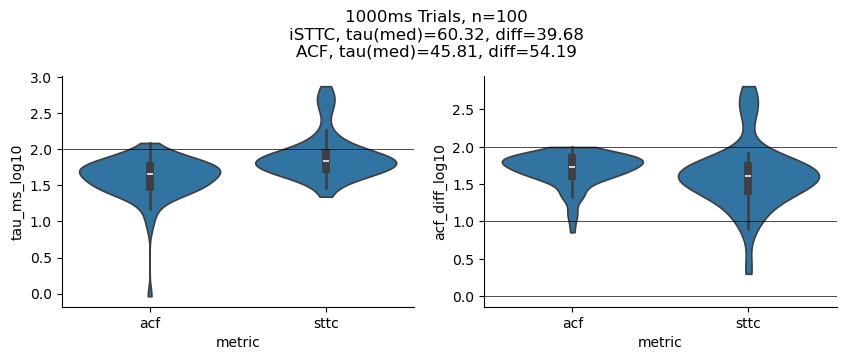

In [50]:
fig, axes = plt.subplots(1,2, figsize=(10,3))

sns.violinplot(ax=axes[0], x='metric', y='tau_ms_log10', data=temp_full, cut=0,  density_norm='width')
sns.violinplot(ax=axes[1], x='metric', y='acf_diff_log10', data=temp_full, cut=0,  density_norm='width')

axes[0].axhline(y=np.log10(100), color='k', lw=0.5)
axes[1].axhline(y=np.log10(1), color='k', lw=0.5)
axes[1].axhline(y=np.log10(10), color='k', lw=0.5)
axes[1].axhline(y=np.log10(100), color='k', lw=0.5)

# axes.axhline(y=10, color='k', lw=0.5)
# axes.axhline(y=-10, color='k', lw=0.5)
# axes.axhline(y=20, color='k', lw=0.5)
# axes.axhline(y=-20, color='k', lw=0.5)
# axes.axhline(y=30, color='k', lw=0.5)
# axes.axhline(y=-30, color='k', lw=0.5)

fig.suptitle('1000ms Trials, n=100' + '\n'+ 'iSTTC, tau(med)={}, diff={}'.
             format(np.round(isttc_med_100, 2), np.round(100-isttc_med_100, 2)) + '\n'+ 'ACF, tau(med)={}, diff={}'.
             format(np.round(acf_med_100, 2), np.round(100-acf_med_100, 2)), 
             y=1.1)

sns.despine()

fig.savefig(fig_folder + 'trials_1s_signal_0_1000_violin.png' , bbox_inches='tight')
fig.savefig(fig_folder + 'trials_1s_signal_0_1000_violin.svg' , bbox_inches='tight')

#### Taus [0, 100]

In [27]:
tau_ms_isttc_acf_a = np.asarray(tau_ms_isttc_acf_l)
tau_ms_isttc_acf_a_0_100 = tau_ms_isttc_acf_a[tau_ms_isttc_acf_a <= 100]
#print(tau_ms_isttc_acf_a_0_100.shape, tau_ms_isttc_acf_a_0_100)

tau_ms_acf_a = np.asarray(tau_ms_acf_l)
tau_ms_acf_a_0_100 = tau_ms_acf_a[tau_ms_acf_a <= 100]
#print(tau_ms_acf_a_0_100.shape, tau_ms_acf_a_0_100)

isttc_med_100 = np.nanmedian(tau_ms_isttc_acf_a_0_100)
acf_med_100 = np.nanmedian(tau_ms_acf_a_0_100)
print('isttc_med: {}, acf_med: {}'.format(isttc_med_100, acf_med_100))

isttc_mean_100 = np.nanmean(tau_ms_isttc_acf_a_0_100)
acf_mean_100 = np.nanmean(tau_ms_acf_a_0_100)
print('isttc_mean: {}, acf_mean: {}'.format(isttc_mean_100, acf_mean_100))

isttc_med: 60.31942719567715, acf_med: 45.81075927511712
isttc_mean: 60.7797941522967, acf_mean: 45.27387702201306


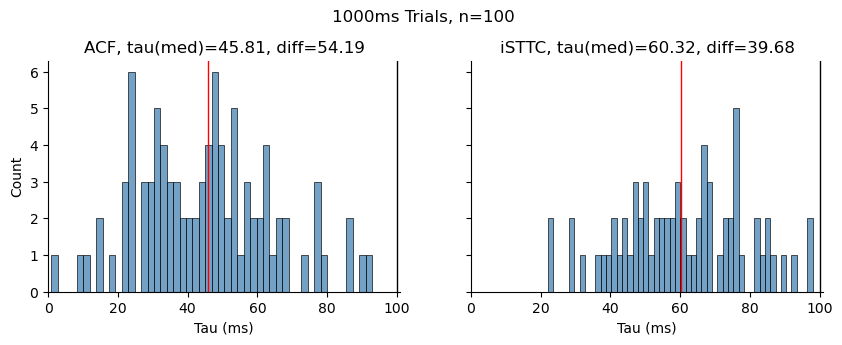

In [48]:
fig, axes = plt.subplots(1,2, figsize=(10,3), sharey=True)

sns.histplot(ax=axes[1], x=tau_ms_isttc_acf_a_0_100, bins=50, stat='count', color='steelblue')
axes[1].axvline(x=isttc_med_100, lw=1, color='red')
axes[1].set_title('iSTTC, tau(med)={}, diff={}'.format(np.round(isttc_med_100, 2), np.round(100-isttc_med_100, 2)))

sns.histplot(ax=axes[0], x=tau_ms_acf_a_0_100, bins=50, stat='count', color='steelblue')
axes[0].axvline(x=acf_med_100, lw=1, color='red')
axes[0].set_title('ACF, tau(med)={}, diff={}'.format(np.round(acf_med_100, 2), np.round(100-acf_med_100, 2)))

fig.suptitle('1000ms Trials, n=100', y=1.05)

for ax in axes.flat:
    ax.axvline(x=100, lw=1, color='k')
    ax.set_xlabel('Tau (ms)')
    ax.set_xlim([0, 101])

sns.despine()

fig.savefig(fig_folder + 'trials_1s_signal_0_1000.png' , bbox_inches='tight')
fig.savefig(fig_folder + 'trials_1s_signal_0_1000.svg' , bbox_inches='tight')